In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed
from collections import OrderedDict

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch_seed(42)
exp_dir = '/Volume/VAD/LifeLongerAD_cu121/results/CFGCAD/MVTecAD/baseline6_200epoch-3_5_with_5_step-Continual_True-online_False/seed_42/'
cfg_dir = os.path.join(exp_dir,'configs.yaml')
cfg = OmegaConf.load(cfg_dir)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 2,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


# 3_5_with_5_step

In [9]:
cn = cfg.DATASET.class_names[0]
test_loader = loader_dict[cn]['test']

cn = cfg.DATASET.class_names[4]
model.load_state_dict(
        torch.load(
            os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
        )
    )



model.eval()
model = model.cuda()

backbone = model.backbone
neck = model.neck 
reconstruction = model.reconstruction 

output_encoder_list = [] 
with torch.no_grad():
    align = [] 
    recon = [] 
    cls_list = [] 
    label_list = [] 
    for step, (images, labels, class_labels, gts) in enumerate(test_loader):
        Input = {'image':images.to('cuda'),'clslabel':class_labels.to('cuda')}
        cls_list.append(class_labels.numpy())
        label_list.append(labels.numpy())
        
        
        task_id = Input.get('clslabel')
        
            
        output = backbone(Input)            
        Input.update(output)
        
        output = neck(Input)
        Input.update(output)
        
        #! output = reconstruction(Input)
        self = reconstruction 
        
        feature_align = Input['feature_align']
        src, pos_embed = self.forward_pre(feature_align)
        
        B = feature_align.shape[0]
            
        uncond_mask = torch.rand(B, device=device) < self.uncond_prob
        masked_task_id = task_id.clone()
        masked_task_id[uncond_mask] = self.null_token_idx

        task_emb = self.task_embedding(masked_task_id) # B, D_cfg
        task_emb_proj = self.task_proj(task_emb) # B, D_feat
        task_embedding = task_emb_proj.unsqueeze(0)
                                
        #! output_decoder, _ = self.transformer(src, pos_embed, task_emb_proj.unsqueeze(0)) # mask 인자 필요시 추가
        self = self.transformer
        
        target_size = (14, 14)        
        
        
        _, batch_size, _ = src.shape
        pos_embed = torch.cat(
            [pos_embed.unsqueeze(1)] * batch_size, dim=1
        )  # (H X W) x B x C

        if self.neighbor_mask:
            mask = self.generate_mask(
                self.feature_size, self.neighbor_mask.neighbor_size
            )
            mask_enc = mask if self.neighbor_mask.mask[0] else None
            mask_dec1 = mask if self.neighbor_mask.mask[1] else None
            mask_dec2 = mask if self.neighbor_mask.mask[2] else None
        else:
            mask_enc = mask_dec1 = mask_dec2 = None

        output_encoder, task_embedding = self.encoder(
            src, mask=mask_enc, pos=pos_embed,  task_embedding=task_embedding
        )  # (H X W) x B x C
        
        
        
        output_encoder_list.append(output_encoder.detach().cpu().numpy())
        
        output = reconstruction(Input)
        Input.update(output)            
        
output_encoder_list = np.concatenate(output_encoder_list,1).mean(0)
cls_list = np.concatenate(cls_list)
label_list = np.concatenate(label_list)
    
with torch.no_grad():
    align = [] 
    recon = [] 
    for step, (images, labels, class_labels, gts) in enumerate(test_loader):
        Input = {'image':images.to('cuda'),'clslabel':class_labels.to('cuda')}
        outputs = model(Input) 
        align.append(outputs['feature_align'].detach().cpu().numpy())
        recon.append(outputs['feature_rec'].detach().cpu().numpy())        
        
align = np.vstack(align).mean(3).mean(2)
recon = np.vstack(recon).mean(3).mean(2)
    


def get_df(feature, cls_list, label_list):
    feature = pd.DataFrame(feature)
    feature['cls_name'] = cls_list 
    feature['label'] = label_list 
    return feature 

def get_tsne(feature):
    tsne = TSNE() 
    feature = tsne.fit_transform(feature)
    return feature 

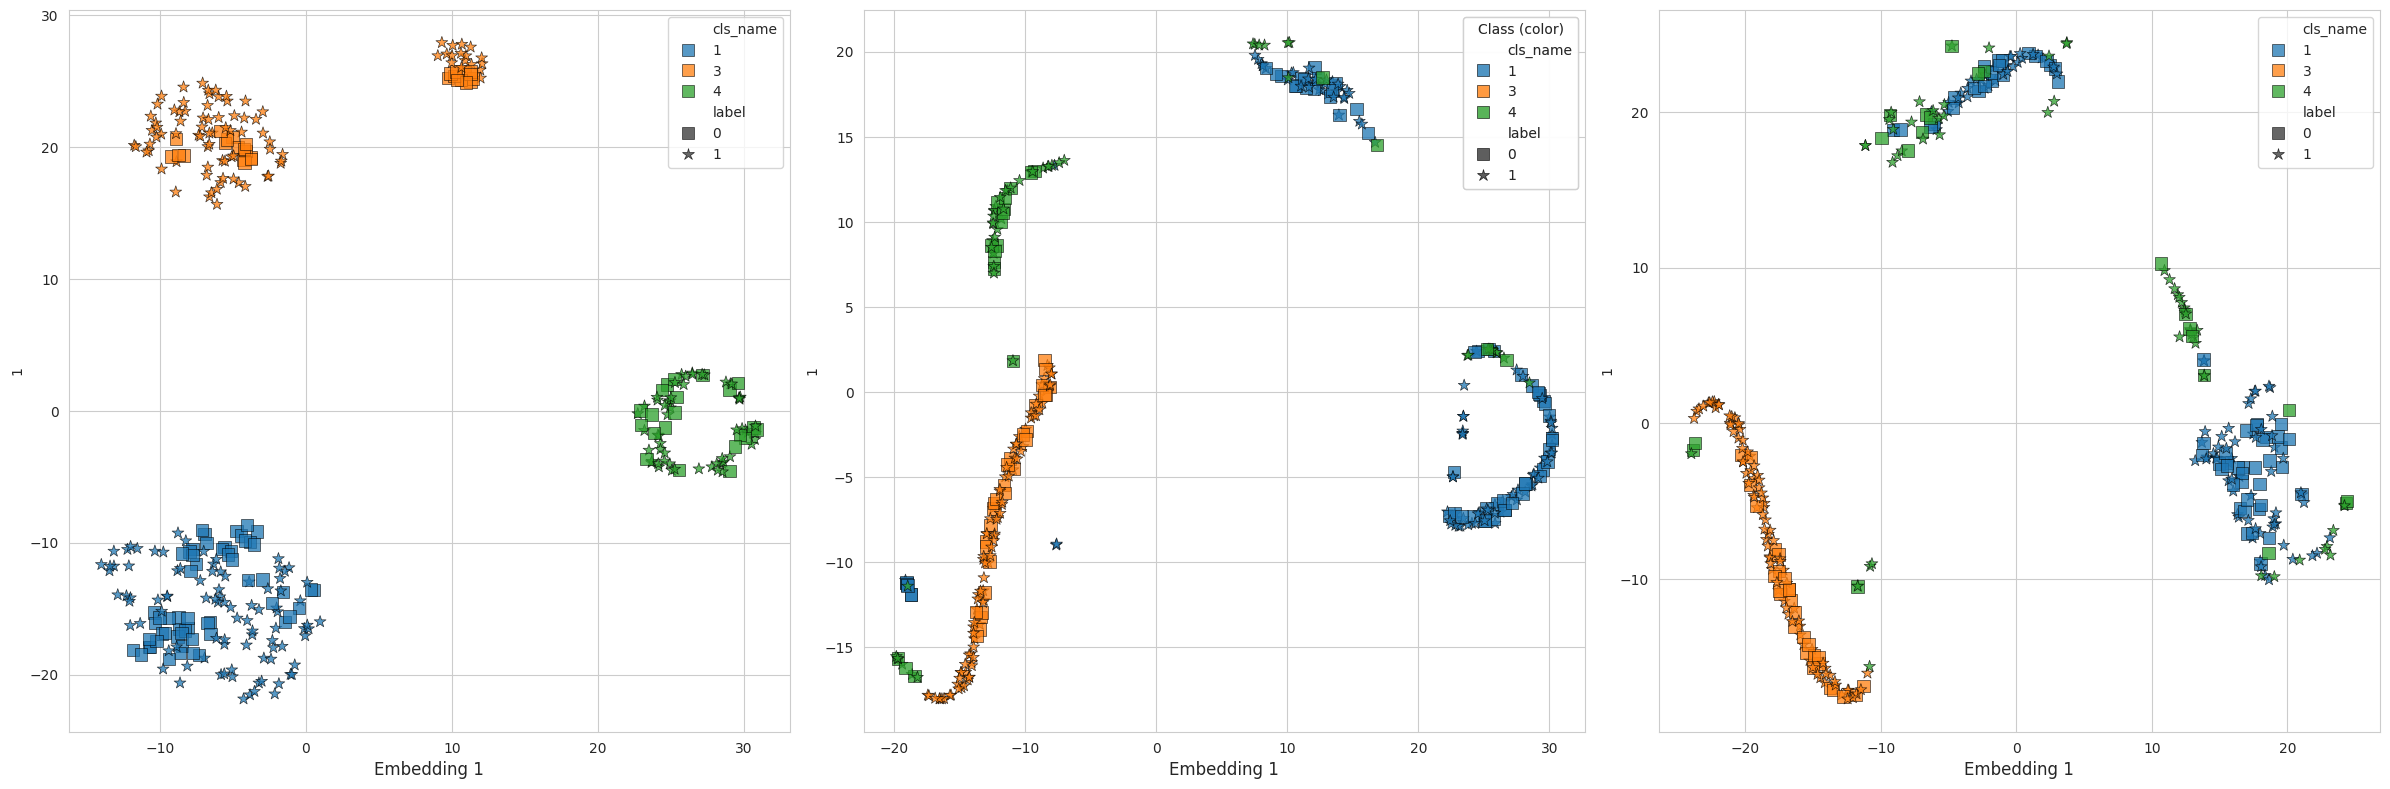

In [10]:
# 스타일 설정
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,3, figsize=(24, 8))


for n in range(1):
    
    align = get_tsne(align)
    recon = get_tsne(recon)
    output_encoder_list = get_tsne(output_encoder_list)
    align_re, recon_re, enc_re = [get_df(f,cls_list, label_list) for f in [align, recon, output_encoder_list]]    


    unique_labels = align_re['label'].unique()
    marker_list = ['*', 's']  # 필요 개수만큼 늘려주세요
    marker_dict = dict(zip(unique_labels, marker_list))

    for i, data in enumerate([align_re,enc_re,recon_re]):
        sns.scatterplot(
            x=0, y=1,
            hue='cls_name',         # 색깔 매핑
            style='label',          # 모양 매핑
            markers=marker_dict,    # label별 모양 사전
            palette='tab10',
            s=80,
            alpha=0.75,
            edgecolor='k',
            linewidth=0.5,
            data=data,
            ax=axes[i]
        )

        axes[i].set_xlabel('Embedding 1', fontsize=12)
        # ax.set_ylabel('Embedding 2', fontsize=12)

        # 범례 위치 조정: 두 개의 범례(색깔·모양)를 따로 표시
        if i == 1:
            leg1 = axes[i].legend(title='Class (color)', loc='upper right')
            axes[i].add_artist(leg1)

plt.tight_layout()
plt.show()

# 10_1_5_with_5step

In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed
from collections import OrderedDict

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch_seed(42)
exp_dir = '/Volume/VAD/LifeLongerAD_cu121/results/CFGCAD/MVTecAD/baseline6_200epoch-10_1_with_5_step-Continual_True-online_False/seed_42/'
cfg_dir = os.path.join(exp_dir,'configs.yaml')
cfg = OmegaConf.load(cfg_dir)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 2,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


In [6]:
def get_output_features(model,test_loader):
    model.eval()
    model = model.cuda()

    backbone = model.backbone
    neck = model.neck 
    reconstruction = model.reconstruction 

    output_encoder_list = [] 
    with torch.no_grad():
        align = [] 
        recon = [] 
        cls_list = [] 
        label_list = [] 
        for step, (images, labels, class_labels, gts) in enumerate(test_loader):
            Input = {'image':images.to('cuda'),'clslabel':class_labels.to('cuda')}
            cls_list.append(class_labels.numpy())
            label_list.append(labels.numpy())
            
            
            task_id = Input.get('clslabel')
            
                
            output = backbone(Input)            
            Input.update(output)
            
            output = neck(Input)
            Input.update(output)
            
            #! output = reconstruction(Input)
            self = reconstruction 
            
            feature_align = Input['feature_align']
            src, pos_embed = self.forward_pre(feature_align)
            
            B = feature_align.shape[0]
                
            uncond_mask = torch.rand(B, device=device) < self.uncond_prob
            masked_task_id = task_id.clone()
            masked_task_id[uncond_mask] = self.null_token_idx

            task_emb = self.task_embedding(masked_task_id) # B, D_cfg
            task_emb_proj = self.task_proj(task_emb) # B, D_feat
            task_embedding = task_emb_proj.unsqueeze(0)
                                    
            #! output_decoder, _ = self.transformer(src, pos_embed, task_emb_proj.unsqueeze(0)) # mask 인자 필요시 추가
            self = self.transformer
            
            target_size = (14, 14)        
            
            
            _, batch_size, _ = src.shape
            pos_embed = torch.cat(
                [pos_embed.unsqueeze(1)] * batch_size, dim=1
            )  # (H X W) x B x C

            if self.neighbor_mask:
                mask = self.generate_mask(
                    self.feature_size, self.neighbor_mask.neighbor_size
                )
                mask_enc = mask if self.neighbor_mask.mask[0] else None
                mask_dec1 = mask if self.neighbor_mask.mask[1] else None
                mask_dec2 = mask if self.neighbor_mask.mask[2] else None
            else:
                mask_enc = mask_dec1 = mask_dec2 = None

            output_encoder, task_embedding = self.encoder(
                src, mask=mask_enc, pos=pos_embed,  task_embedding=task_embedding
            )  # (H X W) x B x C
            
            
            
            output_encoder_list.append(output_encoder.detach().cpu().numpy())
            
            output = reconstruction(Input)
            Input.update(output)            
            
    output_encoder_list = np.concatenate(output_encoder_list,1).mean(0)
    cls_list = np.concatenate(cls_list)
    label_list = np.concatenate(label_list)
    
    return output_encoder_list, cls_list, label_list 

def get_in_out_feature(model,test_loader):
    model.eval()
    model = model.cuda()
    with torch.no_grad():
        align = [] 
        recon = [] 
        for step, (images, labels, class_labels, gts) in enumerate(test_loader):
            Input = {'image':images.to('cuda'),'clslabel':class_labels.to('cuda')}
            outputs = model(Input) 
            align.append(outputs['feature_align'].detach().cpu().numpy())
            recon.append(outputs['feature_rec'].detach().cpu().numpy())        
            
    align = np.vstack(align).mean(3).mean(2)
    recon = np.vstack(recon).mean(3).mean(2)
    
    return align, recon, outputs

def get_df(feature, cls_list, label_list):
    feature = pd.DataFrame(feature)
    feature['cls_name'] = cls_list 
    feature['label'] = label_list 
    return feature 

def get_tsne(feature):
    tsne = TSNE() 
    feature = tsne.fit_transform(feature)
    return feature 

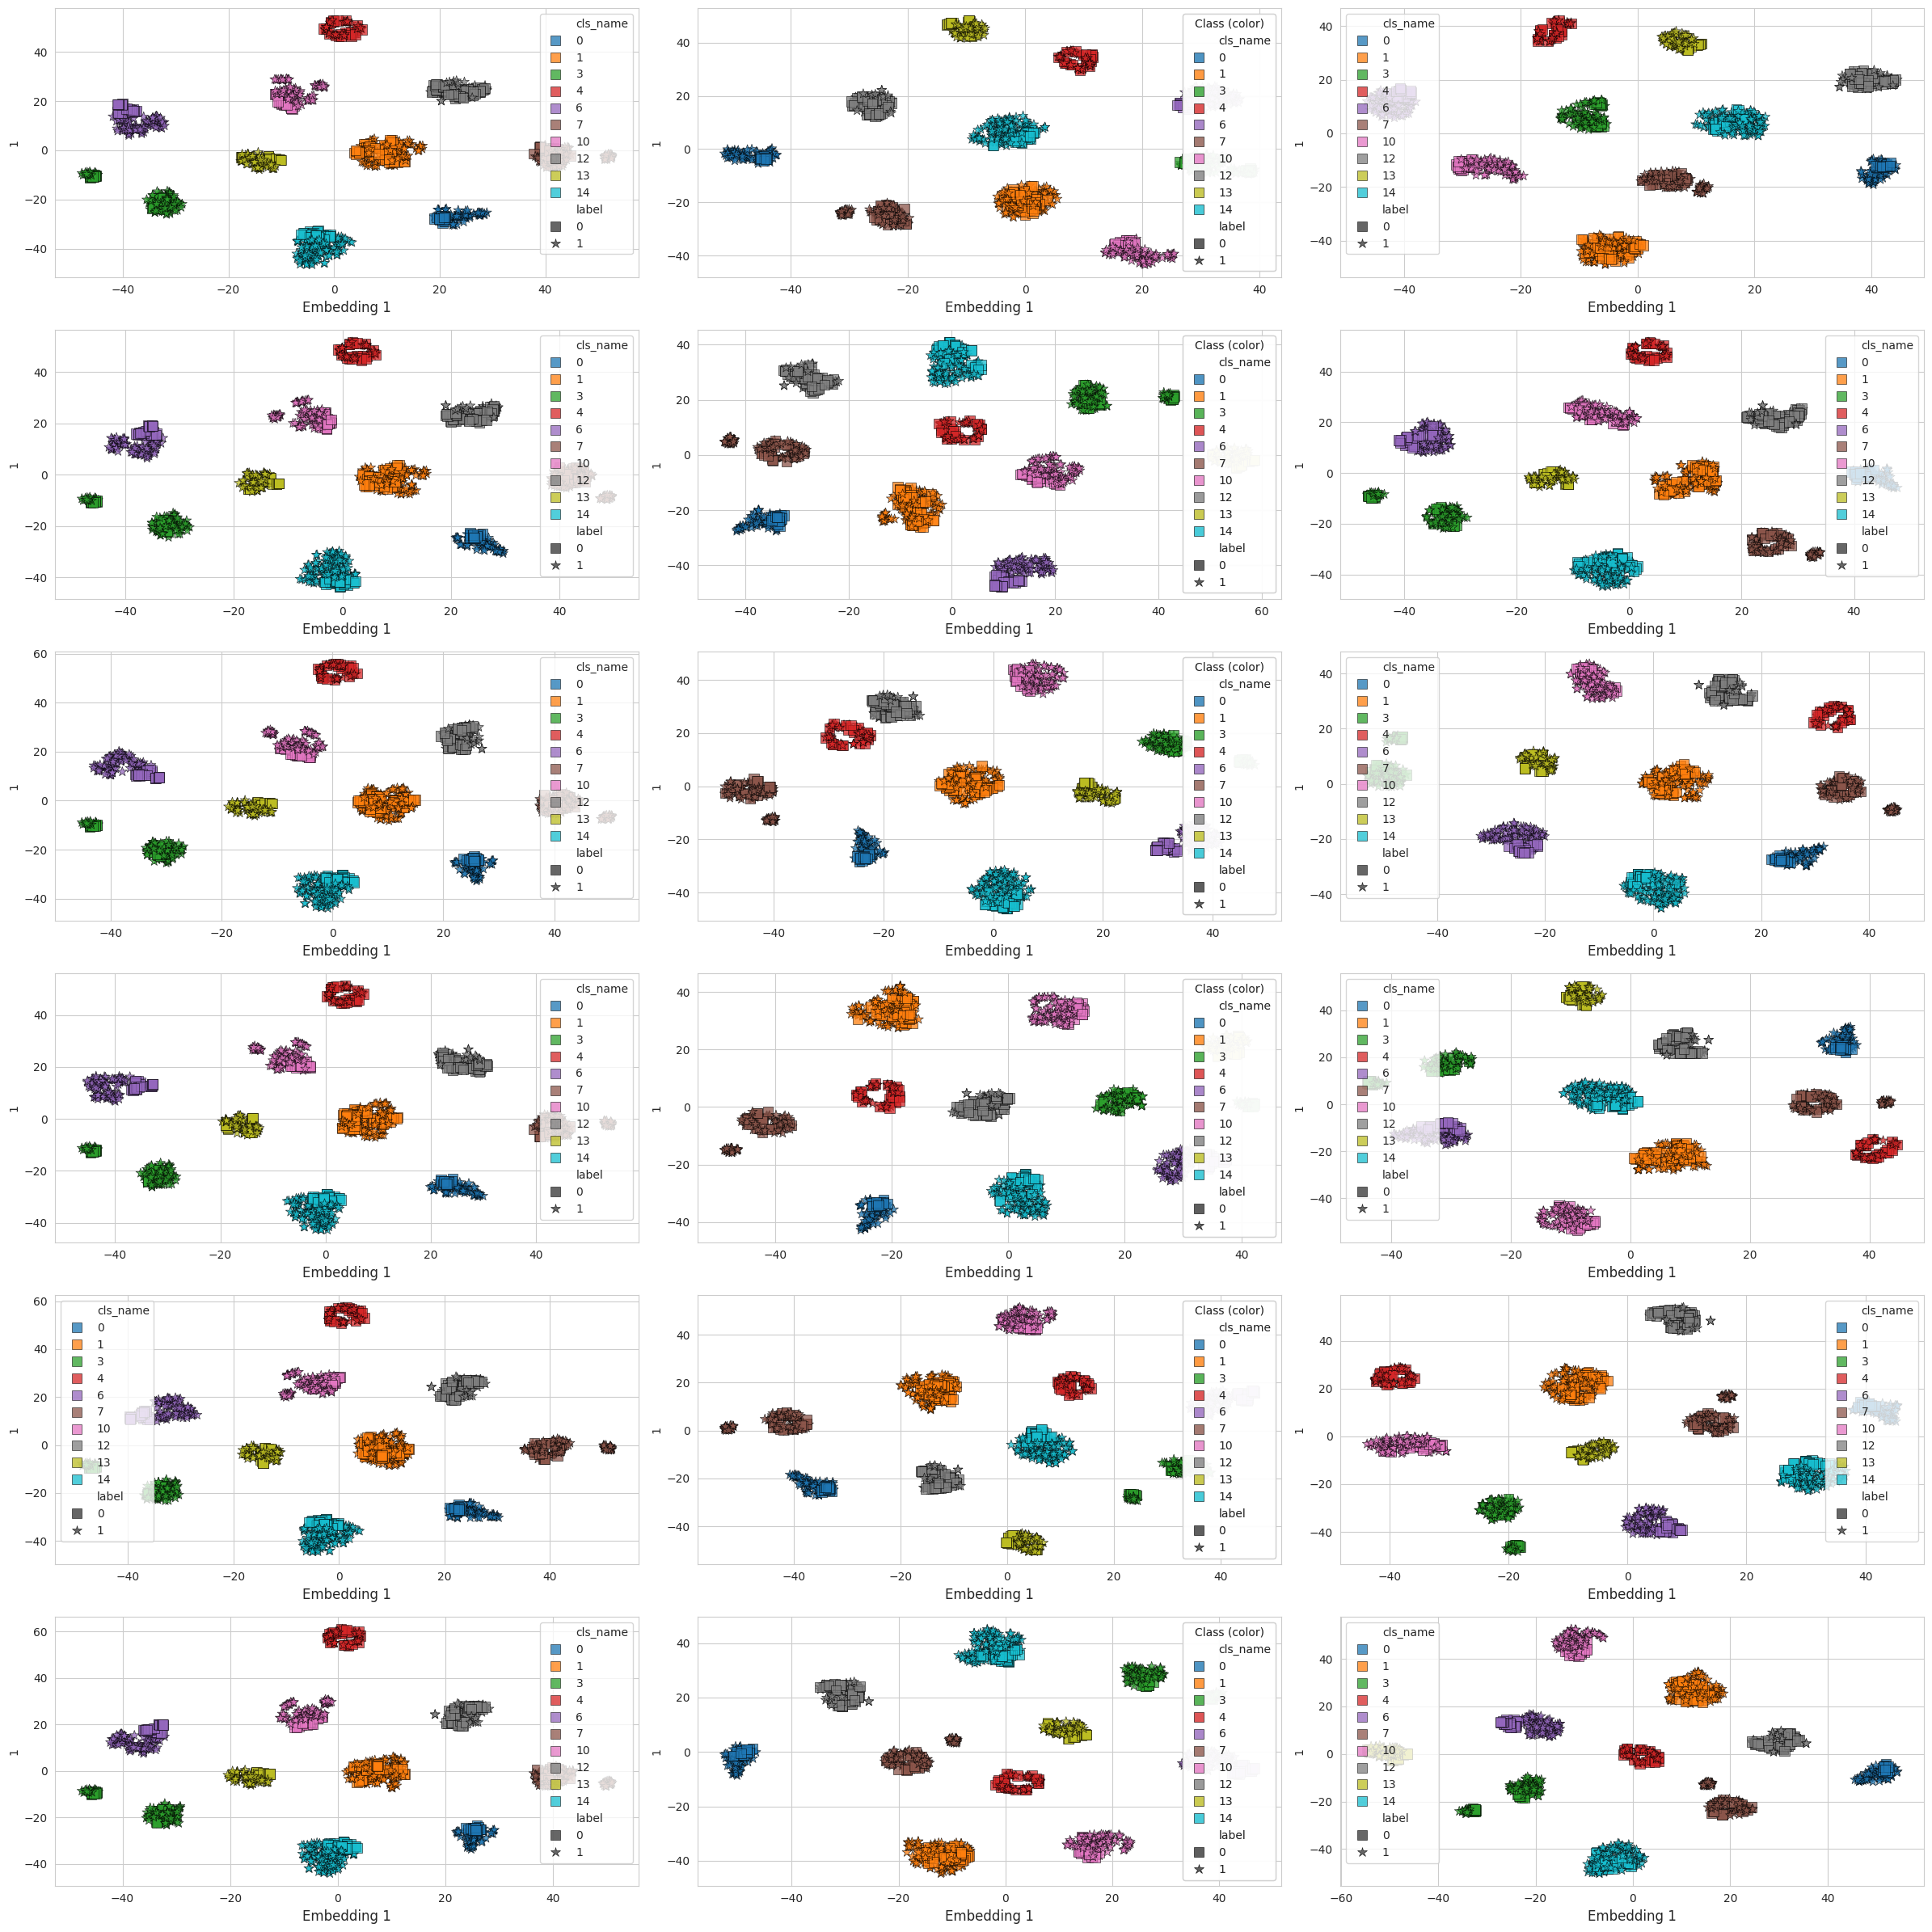

In [5]:
# 스타일 설정
sns.set_style('whitegrid')
fig, axes = plt.subplots(6,3, figsize=(24, 24))


for n in range(len(loader_dict)):
    cn = cfg.DATASET.class_names[0]
    test_loader = loader_dict[cn]['test']

    output_encoder_list, cls_list, label_list  = get_output_features(model, test_loader)
    align, recon = get_in_out_feature(model, test_loader)

    cn = cfg.DATASET.class_names[n]
    model_weight = os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
    weight = torch.load(model_weight)
    model.load_state_dict(weight)    
    model = model.cuda()

    
    align = get_tsne(align)
    recon = get_tsne(recon)
    output_encoder_list = get_tsne(output_encoder_list)
    align_re, recon_re, enc_re = [get_df(f,cls_list, label_list) for f in [align, recon, output_encoder_list]]    


    unique_labels = align_re['label'].unique()
    marker_list = ['*', 's']  # 필요 개수만큼 늘려주세요
    marker_dict = dict(zip(unique_labels, marker_list))

    for i, data in enumerate([align_re,enc_re,recon_re]):
        sns.scatterplot(
            x=0, y=1,
            hue='cls_name',         # 색깔 매핑
            style='label',          # 모양 매핑
            markers=marker_dict,    # label별 모양 사전
            palette='tab10',
            s=80,
            alpha=0.75,
            edgecolor='k',
            linewidth=0.5,
            data=data,
            ax=axes[n,i]
        )

        axes[n,i].set_xlabel('Embedding 1', fontsize=12)
        # ax.set_ylabel('Embedding 2', fontsize=12)

        # 범례 위치 조정: 두 개의 범례(색깔·모양)를 따로 표시
        if i == 1:
            leg1 = axes[n,i].legend(title='Class (color)', loc='upper right')
            axes[n,i].add_artist(leg1)

plt.tight_layout()
plt.show()

# temp 

In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed
from collections import OrderedDict

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch_seed(42)
exp_dir = '/Volume/VAD/LifeLongerAD_cu121/results/CFGCAD/MVTecAD/baseline6_200epoch-10_1_with_5_step-Continual_True-online_False/seed_42/'
cfg_dir = os.path.join(exp_dir,'configs.yaml')
cfg = OmegaConf.load(cfg_dir)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 2,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


In [2]:
model.eval()
model = model.cuda()

backbone = model.backbone
neck = model.neck 
reconstruction = model.reconstruction 

output_encoder_list = [] 
with torch.no_grad():
    align = [] 
    recon = [] 
    cls_list = [] 
    label_list = [] 
    for step, (images, labels, class_labels, gts) in enumerate(testloader):
        Input = {'image':images.to('cuda'),'clslabel':class_labels.to('cuda')}
        cls_list.append(class_labels.numpy())
        label_list.append(labels.numpy())
        
        
        task_id = Input.get('clslabel')
        
            
        output = backbone(Input)            
        Input.update(output)
        
        output = neck(Input)
        Input.update(output)
        
        #! output = reconstruction(Input)
        self = reconstruction 
        
        # feature_align = Input['feature_align']
        # src, pos_embed = self.forward_pre(feature_align)
        
        # B = feature_align.shape[0]
            
        # uncond_mask = torch.rand(B, device=device) < self.uncond_prob
        # masked_task_id = task_id.clone()
        # masked_task_id[uncond_mask] = self.null_token_idx

        # task_emb = self.task_embedding(masked_task_id) # B, D_cfg
        # task_emb_proj = self.task_proj(task_emb) # B, D_feat
        # task_embedding = task_emb_proj.unsqueeze(0)
                                
        # #! output_decoder, _ = self.transformer(src, pos_embed, task_emb_proj.unsqueeze(0)) # mask 인자 필요시 추가
        # self = self.transformer
        
        # target_size = (14, 14)        
        
        
        # _, batch_size, _ = src.shape
        # pos_embed = torch.cat(
        #     [pos_embed.unsqueeze(1)] * batch_size, dim=1
        # )  # (H X W) x B x C

        # if self.neighbor_mask:
        #     mask = self.generate_mask(
        #         self.feature_size, self.neighbor_mask.neighbor_size
        #     )
        #     mask_enc = mask if self.neighbor_mask.mask[0] else None
        #     mask_dec1 = mask if self.neighbor_mask.mask[1] else None
        #     mask_dec2 = mask if self.neighbor_mask.mask[2] else None
        # else:
        #     mask_enc = mask_dec1 = mask_dec2 = None

        # output_encoder, task_embedding = self.encoder(
        #     src, mask=mask_enc, pos=pos_embed,  task_embedding=task_embedding
        # )  # (H X W) x B x C
        
        
        
        # output_encoder_list.append(output_encoder.detach().cpu().numpy())
        break 

In [6]:
Input.keys()

dict_keys(['image', 'clslabel', 'features', 'strides', 'feature_align', 'outplane'])

In [ ]:
feature_align = Input['feature_align']
model.reconstruction(Input)

In [17]:
output[1].shape

torch.Size([2, 64, 2, 2])

In [24]:
output.shape

torch.Size([2, 272, 14, 14])

In [27]:
model.reconstruction.rec_head

Linear(in_features=256, out_features=272, bias=True)